In [2]:
import cv2
from textwrap import wrap
import shutil
import pandas as pd
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow_addons as tfa
import os, warnings
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
import numpy as np
import random

print('TensorFlow Version ' + tf.__version__)

def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed_everything()

import warnings
warnings.filterwarnings("ignore")

C:\Users\Admin\Documents\xkocian\VisionTrasnformer\venv\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
C:\Users\Admin\Documents\xkocian\VisionTrasnformer\venv\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to enco

TensorFlow Version 2.10.0


In [3]:
image_size = 224
batch_size = 16
n_classes = 3
EPOCHS = 40

train_path = 'test_smote_images'

classes = {0 : "Dry",
           1 : "Normal",
           2 : "Wet"}

In [4]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_rotate = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_1 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    p_pixel_3 = tf.random.uniform([], 0, 1.0, dtype = tf.float32)
    
    # Flips
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    
    if p_spatial > .75:
        image = tf.image.transpose(image)
        
    # Rotates
    if p_rotate > .75:
        image = tf.image.rot90(image, k = 3) # rotate 270º
    elif p_rotate > .5:
        image = tf.image.rot90(image, k = 2) # rotate 180º
    elif p_rotate > .25:
        image = tf.image.rot90(image, k = 1) # rotate 90º
        
    # Pixel-level transforms
    if p_pixel_1 >= .4:
        image = tf.image.random_saturation(image, lower = .7, upper = 1.3)
    if p_pixel_3 >= .4:
        image = tf.image.random_brightness(image, max_delta = .1)
        
    return image

In [5]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                          samplewise_center = True,
                                                          samplewise_std_normalization = True,
                                                          validation_split = 0.3,
                                                          dtype='float16'
                                                        
                                                          )
# set as training data

train_gen  = datagen.flow_from_directory(
    train_path,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = True,
    class_mode='categorical',
    subset='training') 

# same directory as training data

valid_gen  = datagen.flow_from_directory(
    train_path ,
    target_size=(image_size, image_size),
    batch_size = batch_size,
    seed = 1,
    color_mode = 'rgb',
    shuffle = False,
    class_mode='categorical',
    subset='validation',
    )

class_indices_mapping = train_gen.class_indices

Found 5232 images belonging to 3 classes.
Found 2241 images belonging to 3 classes.


In [6]:
def values(generator):
    total_images = generator.n  
    steps = total_images//batch_size 
    #iterations to cover all data, so if batch is 5, it will take total_images/5  iteration 

    x , y = [] , []
    for i in range(steps):
        a , b = generator.next()
        x.extend(a) 
        y.extend(b)
    return np.array(x), np.array(y)

In [7]:
class Patches(L.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides = [1, self.patch_size, self.patch_size, 1],
            rates = [1, 1, 1, 1],
            padding = 'VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Image size: 224 X 224
Patch size: 7 X 7
Patches per image: 1024
Elements per patch: 147


<Figure size 400x400 with 0 Axes>

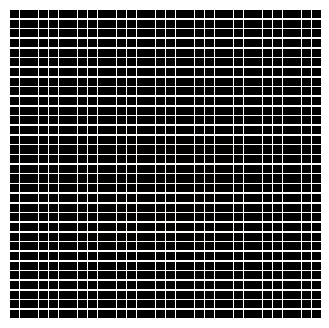

In [8]:
plt.figure(figsize=(4, 4))
patch_size = 7  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2

x = train_gen.next()
image = x[0][0]



resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size = (image_size, image_size)
)

patches = Patches(patch_size)(resized_image)
print(f'Image size: {image_size} X {image_size}')
print(f'Patch size: {patch_size} X {patch_size}')
print(f'Patches per image: {patches.shape[1]}')
print(f'Elements per patch: {patches.shape[-1]}')

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))

for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis('off')

In [9]:
from vit_keras import vit

vit_model = vit.vit_b16(
        image_size = image_size,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 5)

In [10]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(128, activation = tf.keras.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(64, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(32, activation = tf.keras.activations.gelu),
        tf.keras.layers.Dense(3, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (BatchN  (None, 768)              3072      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               98432     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)         

In [11]:
warnings.filterwarnings("ignore")

learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = learning_rate)

model.compile(optimizer = optimizer, 
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2), 
              metrics = ['accuracy'])

STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size



early_stopping_callbacks = tf.keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True, verbose = 1)
filepath = "checkpoints/pt-miority-saved-model-{epoch:02d}.keras"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)

History = model.fit(x = train_gen,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = valid_gen,
          validation_steps = STEP_SIZE_VALID,
          epochs = 20,
          callbacks = [early_stopping_callbacks, model_checkpoint_callback])

model.save("smoted.keras")

Epoch 1/20
327/327 [==============================] - 135s 349ms/step - loss: 0.9948 - accuracy: 0.5703 - val_loss: 0.8172 - val_accuracy: 0.7594
Epoch 2/20
327/327 [==============================] - 107s 329ms/step - loss: 0.7224 - accuracy: 0.8394 - val_loss: 0.6795 - val_accuracy: 0.8857
Epoch 3/20
327/327 [==============================] - 108s 331ms/step - loss: 0.6151 - accuracy: 0.9220 - val_loss: 0.7664 - val_accuracy: 0.8228
Epoch 4/20
327/327 [==============================] - 108s 329ms/step - loss: 0.5647 - accuracy: 0.9580 - val_loss: 0.5828 - val_accuracy: 0.9446
Epoch 5/20
327/327 [==============================] - 108s 330ms/step - loss: 0.5393 - accuracy: 0.9729 - val_loss: 0.6119 - val_accuracy: 0.9223
Epoch 6/20
327/327 [==============================] - 108s 329ms/step - loss: 0.5388 - accuracy: 0.9694 - val_loss: 0.5592 - val_accuracy: 0.9598
Epoch 7/20
327/327 [==============================] - 109s 333ms/step - loss: 0.5227 - accuracy: 0.9813 - val_loss: 0.5292 -

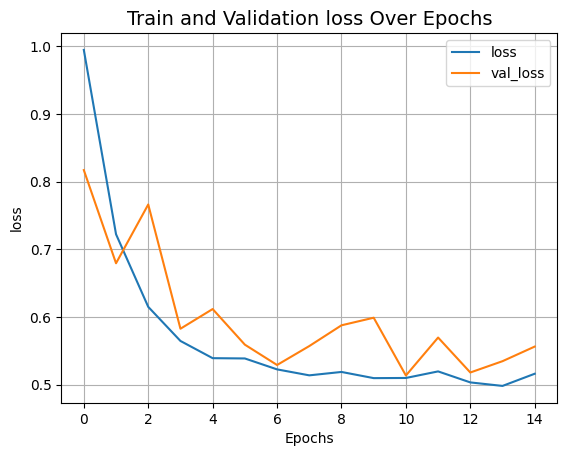

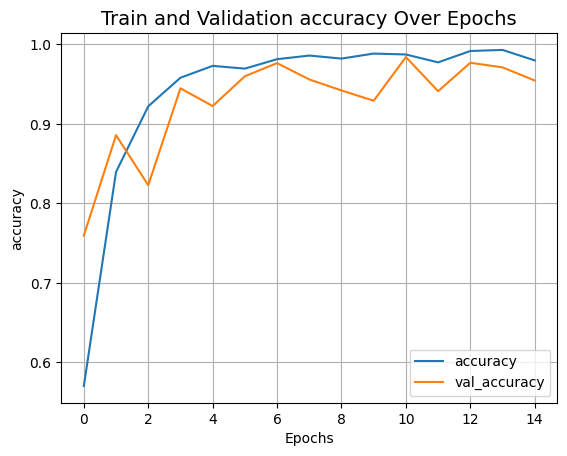

In [13]:
def plot_history(item):
    plt.plot(History.history[item], label=item)
    plt.plot(History.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_history("loss")
plot_history("accuracy")

141/141 [==============================] - 15s 101ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       747
           1       0.97      0.98      0.98       747
           2       0.99      1.00      0.99       747

    accuracy                           0.98      2241
   macro avg       0.98      0.98      0.98      2241
weighted avg       0.98      0.98      0.98      2241


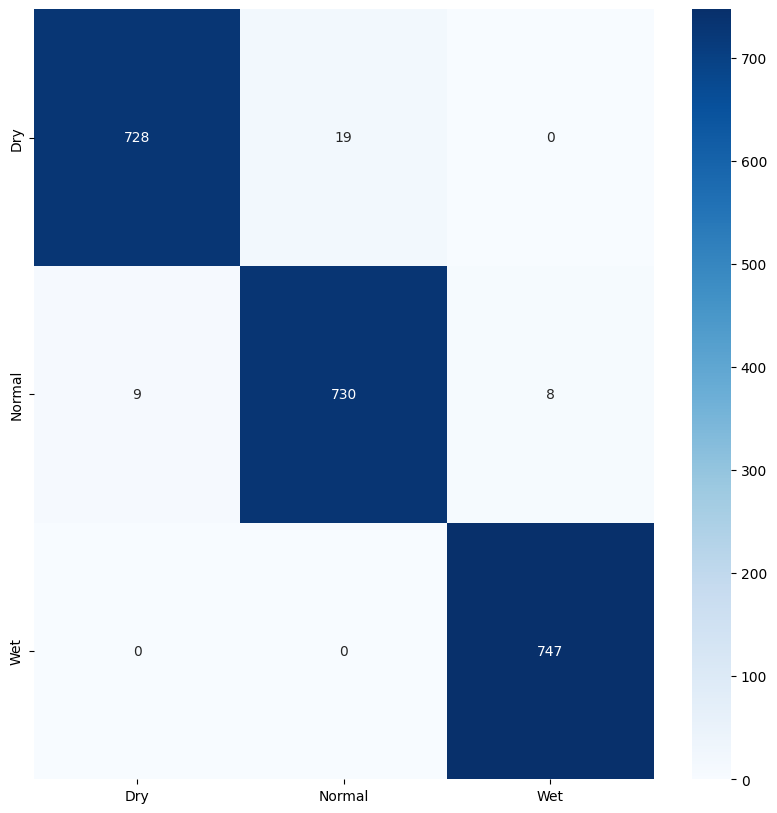

In [22]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

predicted_classes = np.argmax(model.predict(valid_gen, steps = valid_gen.n // valid_gen.batch_size + 1), axis = 1)
true_classes = valid_gen.classes
class_labels = list(valid_gen.class_indices.keys()) 
confusionmatrix = confusion_matrix(true_classes, predicted_classes)
plt.figure(figsize = (10, 10))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True ,fmt='g',xticklabels=class_labels, yticklabels=class_labels)

print(classification_report(true_classes, predicted_classes))